# Wedgex

Use an analytical solution for particle trajectories in an orogenic wedge, use the particle depths to calculate thermochronometer cooling ages and compare to thermochronology data. 


## Workflow:

This notebook can be used to run a single model and show the calculated particle trajectories, exhumation rates and thermochronology ages. 

The default parameters and data are based on the Kuru Chu cross-section in the Himalayas, a well studied cross section which was explored Long et al. (2012, https://doi.org/10.1029/2012TC003155), Coutand et al. (2014, https://doi.org/10.1002/2013JB010891) and McQuarrie and Ehlers (2015, https://doi.org/10.1002/2014TC003783).

The thermochronology data that are used are located in the file [data/thermochron_data_projected.csv](data/thermochron_data_projected.csv). This file was created by a separate notebook [utilities/extract_xsection_data.ipynb](utilities/extract_xsection_data.ipynb), which automatically extracts thermochronology data along a cross-section.

## Import modules

In [1]:
import string
import itertools
import numpy as np
import matplotlib.pyplot as pl
import pandas as pd

import sklearn.metrics

import scipy.optimize

import astropy.units as u

# equations for particle trajectories
import wedgeqs

# function wrappers to run multiple models and compare modelled and measured thermochron ages
import wedgex_model_functions

# optional: advective-conductive heat flow model
import lib.heat_flow_model as hf

In [2]:
pl.rcParams['mathtext.default'] = 'regular'

In [3]:
try:
    from cmcrameri import cm
    cmap = cm.batlow
    #cmap_heat = cm.vik
    cmap_heat = cm.roma_r
except:
    print("failed to import fabio crameris colormaps, using matplotlib viridis and coolwarm colormaps instead")
    cmap = 'viridis'
    cmap_heat = 'coolwarm'

## Filenames

In [4]:
# name of file with thermochron data
thermochron_data_file = 'data/thermochron_data_projected.csv'

# column with distance
distance_column = 'projected_distance_along_xsection'
thermochronometer_col = 'system'

# filename for output file with modelled ages thermochron samples
thermochron_output_file = 'data/modelled_thermochron_data.csv'

# output file with modelled ages vs distance
thermochron_profile_file = 'data/modelled_thermochron_profiles.csv'

## Model parameters

In [5]:
year = 365.25 * 24 * 3600.

model_run_name = 'default'

# specify convergence and partitioning coeffiicnets. leave at None to specify the wedge deformation parameters directly
# conv = None
#conv = 20e-3 * u.m / u.year
#conv_part = 0.7
#deform_part = 0.5

# 
#conv = 20e-3 * u.m / u.year
#conv_part = 0.5
#deform_part = 0.5

# default runs first version ms
#conv, conv_part, deform_part = 0.020 * u.m / u.year, 0.5, 0.5

# calibrated values fixed geothermal gradient:
#conv, conv_part, deform_part = 0.02034093 * u.m / u.year, 0.45786315, 0.53954462

# calibrated values, numerical model, 20 iterations
#conv, conv_part, deform_part = 0.01696995 * u.m / u.year, 0.54582906, 0.48013337

# calibrated values, no MAr:
#0.01759965 0.61853727 0.44335494
#conv, conv_part, deform_part = 0.01759965 * u.m / u.year, 0.61853727, 0.44335494

# calibrated values, no AFT:
#conv, conv_part, deform_part = 0.01781127* u.m / u.year,  0.53840965, 0.5227087 

#calibrated values 100 runs
#conv, conv_part, deform_part, vxa, vya = 1.72942041e-02 * u.m / u.year, 5.50376833e-01,  4.40945995e-01, -2.46932861e-04 * u.m / u.year, -3.14147092e-04 * u.m / u.year

#conv, conv_part, deform_part, vxa, vya =  (1.76170905e-02 * u.m / u.year, 5.71132921e-01,  5.36513219e-01, 
#                                           8.36008298e-06 * u.m / u.year, -3.45930217e-04 * u.m / u.year)
conv, conv_part, deform_part, vxa, vya =  (1.62740946e-02 * u.m / u.year, 5.39300352e-01,  5.42245071e-01, 
                                           1.04312158e-05 * u.m / u.year, 1.00363850e-05 * u.m / u.year)

# 1.62740946e-02 5.39300352e-01 5.42245071e-01 1.04312158e-05 1.00363850e-05

# compressional, transport and accretion velocity
# note these are overwritten if convergence parameters are used above
vc = -5e-3 * u.m / u.year
vd = -5e-3 * u.m / u.year

#
#vxa = 1e-9 * u.m / u.year
#vya = 1e-9 * u.m / u.year

# convergence velocity of the downgoing plate
# note this is the horizontal component, the downgoing component is calculated usign the wedge slope
# note2, this variable is also overwritten if convergence parameters are used
v_downgoing = 1.0e-3 * u.m / u.year

# lenght of wedge (m)
L = 200e3 * u.m

# slope of topography (m/m)
# for McQuarrie & Ehlers: ~ 4km over 117 km 
alpha = 0.034

# slope of bottom of wedge (m/m)
# for McQuarrie & Ehlers: detachment depth at N edge xsection (117 km) = ~20 km
beta = -0.17

# disctance between surface points (m)
x_interval = 5e3 * u.m

x_first_pt = 1e3 * u.m

# number of rows in the orogenic wedge. Used for figures only, no function in the actual model
n_rows = 100

# modelled timespan (years)
max_time = 2e8 * u.year

# timestep size (years)
dt = 1e4 * u.year

# thermochronology model. choose between 'simple' and 'Dodson'
thermochron_model = 'Dodson'
#thermochron_model = 'simple'

# names of thermochronometers, should match the names in your input file
thermochron_systems = ['AHe', 'AFT', 'ZHe', 'ZFT', 'MAr']
# omitting MAr
#thermochron_systems = ['AHe', 'AFT', 'ZHe', 'ZFT']

# thermochron system to show in figure
thermochron_systems_plot = ['AHe', 'AFT', 'ZHe', 'ZFT', 'MAr']


# resetting temperatures (degr. C), note these are only used if thermochron_model = 'simple'
resetting_temperatures = [70.0 * u.deg_C, 110.0  * u.deg_C, 180.0  * u.deg_C, 230.0 * u.deg_C, 325.0 * u.deg_C]

# default exhumation rate, used to calculate ages from the undeformed foreland 
# that have not been reset inside the wedge (m/yr)
default_exhumation_rate = 1e-4 * u.m / u.year

# option to remove non-reset ages from database
remove_non_reset_ages = True

# limit for estimating which ages are reset or not (Ma)
reset_age_limit =  100.0 

# thermal history model. options: 'numerical' for numeircal steady-state model, 'fixed_gradient' for fixed geothermal gradient
thermal_history_model = 'numerical'
#thermal_history_model = 'fixed_gradient'

# geothermal gradient, used to convert resetting temp to depth (degr. C/m) in the case of a fixed_gradient thermal model
geothermal_gradient = 0.015 * u.deg_C / u.m

# surface temperature at sea lvl (degr. C)
surface_temperature_sea_lvl = 24.0 * u.deg_C

# adiabatic lapse rate (C/m), used to calculate surface temperatures
lapse_rate = -7.0 / 1e3 * u.deg_C / u.m

# model domain length of downgoing plate
Lxmin = 100e3 * u.m

# cellsizes for the numerical mesh that is used for the numerical heat flow model
cellsize_wedge_top = 250.0 * u.m
cellsize_wedge_bottom = 2000.0 * u.m
cellsize_footwall = 5000.0 * u.m

# vertical size downgoing plate
Ly = 110e3 * u.m

# temperature boundary conditions
lab_temp = 1300 * u.deg_C

# thermal parameters
K = 2.5 * u.W / (u.m * u.K)
rho = 2700.0 * u.kg / u.m**3
c = 800.0 * u.J / (u.kg * u.K)

# heat prod at surface
H0 = 2.75e-6 * u.W / u.m**3

# e-folding depth heat prod
e_folding_depth = 17500.0

## Options for figures

In [6]:
# figure size, in inches:
fig_width = 170 / 25.4
#fig_width = 140 / 25.4
fig_height = 0.75

# subplot label start, 0 = a
first_subplot = 2

# add legend
add_legend = True

# add
add_equation = False

# show each x particle paths in figure
starting_pt_int = 4

# isochrons to show
isochrons = np.arange(0, 55, 5)

# some figure options
fig_output_file = 'fig/wedgex_model_%s' % model_run_name
fig_formats = ['png', 'pdf', 'svg']

thermochron_markers = ['o', 'd', 's', '^', 'h']
thermochron_colors = ['darkblue', 'blue', 'green', 'red', 'orange']

# isochrons to show in figure:
isochrons = [5e6 * u.year, 10e6  * u.year, 15e6  * u.year, 20e6  * u.year, 25e6  * u.year]

# maximum thermochron age on y-axis
max_age_fig = 20.0 * 1e6 * u.year

# log scale for cooling ages:
log_scale_ages = False

fs = 'small'

gr = 1.618033

# draw flow arrows for one in x particle locations
arrow_int = 250

# scale for flow arrows. higher means smaller arrows
scale = 2.0

#
degree_symbol = chr(176)


## Calculate wedge deformation params if convergence is specified

In [7]:
if conv is not None:

    v_downgoing = conv * conv_part 
    v_wedge = - (1.0 - conv_part) * conv
    vc = deform_part * v_wedge
    vd = (1.0 - deform_part) * v_wedge

## Set up initial particle positions and timesteps

In [8]:
# x-coordinates of starting points:
x0s = np.arange(0, L.to(u.m).value + x_interval.to(u.m).value, x_interval.to(u.m).value) * u.m
x0s[0] = x_first_pt

# timesteps (years)
t = np.arange(0, -max_time.to(u.year).value - dt.to(u.year).value, -dt.to(u.year).value) * u.year

print('particle starting points (m from tip of wedge):\n', x0s)

print('timesteps (yr):\n', t / 1e6)

particle starting points (m from tip of wedge):
 [  1000.   5000.  10000.  15000.  20000.  25000.  30000.  35000.  40000.
  45000.  50000.  55000.  60000.  65000.  70000.  75000.  80000.  85000.
  90000.  95000. 100000. 105000. 110000. 115000. 120000. 125000. 130000.
 135000. 140000. 145000. 150000. 155000. 160000. 165000. 170000. 175000.
 180000. 185000. 190000. 195000. 200000.] m
timesteps (yr):
 [ 0.0000e+00 -1.0000e-02 -2.0000e-02 ... -1.9998e+02 -1.9999e+02
 -2.0000e+02] yr


## Determine isochrons to show in figures

i.e., get the timesteps for the different timeslices that are defined by the variable isochrons

In [9]:
isochron_ts = [np.argmin(np.abs(t - ic)) for ic in isochrons]

## Load thermochron data

In [10]:
df = pd.read_csv(thermochron_data_file)

df[thermochronometer_col].unique()

print('thermochron data systems in file: ', df[thermochronometer_col].unique())

thermochron data systems in file:  ['ZHe' 'AFT' 'MAr']


## Remove anomalously old ages

In [11]:
if remove_non_reset_ages is True:

    print('ages before removing non-reset ages:\n', df['age'].describe())
    
    df = df[df['age'] < reset_age_limit]
    
    print('ages after removing non-reset ages:\n', df['age'].describe())

ages before removing non-reset ages:
 count      48.000000
mean       56.973812
std       245.686577
min         2.700000
25%         4.222500
50%         6.930000
75%         8.940000
max      1395.700000
Name: age, dtype: float64
ages after removing non-reset ages:
 count    46.000000
mean      6.915935
std       2.913004
min       2.700000
25%       4.207500
50%       6.600000
75%       8.615000
max      14.780000
Name: age, dtype: float64


## Get sample data

In [12]:
# get sample positions from dataframe
x0_samples = df[distance_column].values * u.m


#df.head()

measured_ages = df['age'].values * 1e6 * u.year
#data_distance = df['age'].values
measured_ages_sigma = df['age_error_1s'].values * 1e6 * u.year
#resetting_temperatures_samples = df['resetting_temp'].values

thermochron_system_samples = df[thermochronometer_col].values

## Get dimensionless values of params, needed for heat flow module

In [13]:
# remove dimensions
L_, Ly_, Lxmin_, cellsize_wedge_top_, cellsize_wedge_bottom_, cellsize_footwall_ = (L.to(u.m).value, Ly.to(u.m).value, Lxmin.to(u.m).value, 
    cellsize_wedge_top.to(u.m).value, cellsize_wedge_bottom.to(u.m).value, cellsize_footwall.to(u.m).value)

x0_samples_ = x0_samples.to(u.m).value

vd_, vc_, vxa_, vya_, v_downgoing_ = (vd.to(u.m/u.s).value, vc.to(u.m/u.s).value, 
                                      vxa.to(u.m/u.s).value, vya.to(u.m/u.s).value, v_downgoing.to(u.m/u.s).value)

t_ = t.to(u.s).value


## Calculate particle trajectories and ages for all seed points in model domain

In [14]:
from importlib import reload

wedgex_model_functions = reload(wedgex_model_functions)


# particle trajectories 
xp_, yp_, dp_ = wedgex_model_functions.run_model_multiple_samples(t, x0s, 
                                                               alpha, beta, L, 
                                                               vc, vd, vxa, vya)
xp, yp, dp = xp_ * u.m, yp_ * u.m, dp_ * u.m
y0p = xp * alpha

## Get particle trajectories and ages for all samples

In [15]:
x_samples_, y_samples_, d_samples_ = wedgex_model_functions.run_model_multiple_samples(t_, x0_samples_, 
                                                             alpha, beta, L_, 
                                                             vc_, vd_, vxa_, vya_)

x_samples = x_samples_ * u.m
y_samples = y_samples_ * u.m
d_samples = d_samples_ * u.m

y0_samples = x_samples * alpha

## Model the steady-state temperature field

In [16]:
%%time

# cellsize_wedge, cellsize_footwall, lab_temp, 
#                                   K, rho, c, H0, e_folding_depth, v_downgoing

#from importlib import reload

#hf = reload(hf)

if thermal_history_model == 'numerical':

    Tx_, Ty_, T_, q, mesh = hf.model_heat_transport(L_, Ly_, alpha, beta, Lxmin_, 
                                                    cellsize_wedge_top_, cellsize_wedge_bottom_, cellsize_footwall_, 
                                                    vd_, vc_, vxa_, vya_, v_downgoing_, surface_temperature_sea_lvl.value, 
                                                    lapse_rate.value, lab_temp.value, 
                                                    K.value, rho.value, c.value, H0.value, e_folding_depth)

    Tx, Ty, T = Tx_ * u.m, Ty_ * u.m, T_ * u.deg_C
    
    qx, qy = mesh.faceCenters.globalValue
    qxa, qya = q.globalValue
    

    

CPU times: user 1min 20s, sys: 25.6 s, total: 1min 45s
Wall time: 32.2 s


## Check and plot the surface temp

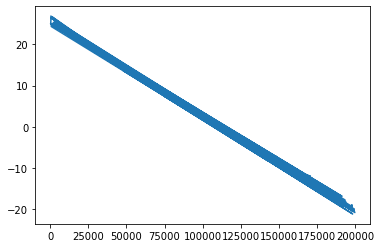

In [17]:
d_num =  alpha * Tx_ - Ty_

ind = (d_num < 100.0) & (Tx_ > 0)

fig, ax = pl.subplots(1, 1)
ax.plot(Tx[ind], T[ind])
#ax.scatter(Tx[ind], d_num[ind], s=1)

## Interpolate modelled temperatures on a regular grid

In [18]:
if thermal_history_model == 'numerical':
    # interpolate to regular grid, useful for plotting later
    dxg = 100.0
    qxy = np.vstack([qx, qy]).T
    xgm, ygm, qxm = hf.interpolate_data(qxy, qxa, dxg, dxg)
    xgm, ygm, qym = hf.interpolate_data(qxy, qya, dxg, dxg)
    
    Txy = np.vstack([Tx_, Ty_]).T
    xTm, yTm, Tm = hf.interpolate_data(Txy, T_, dxg, dxg)
       
    ind = (yTm < (beta * xTm - Ly.value)) & (xTm > 0)
    Tm[ind] = np.nan
    
    ind = (yTm < ( - Ly.value)) & (xTm <= 0)
    Tm[ind] = np.nan

    ind = (ygm < (beta * xgm - Ly.value)) & (xgm > 0)
    qxm[ind] = np.nan
    qym[ind] = np.nan
    
    ind = (ygm < ( - Ly.value)) & (xgm <= 0)
    qxm[ind] = np.nan
    qym[ind] = np.nan


warning, interpolating data on raster with >1e6 nodes
warning, interpolating data on raster with >1e6 nodes
warning, interpolating data on raster with >1e6 nodes


## Calculate thermal history for the seed points

In [19]:
if thermal_history_model == 'numerical':
    T_history_points = wedgex_model_functions.interpolate_thermal_history(xp, yp, Tx, Ty, T)
else:
    print('using a steady geothermal gradient to calculate temperature history')
    # calculate surface temperature
    #surface_temp_samples = surface_temperature_sea_lvl - lapse_rate * xp
    #resetting_depths = (resetting_temperatures - surface_temp_samples) / geothermal_gradient

    #target_depths_samples = resetting_depths

    n_samples = len(x_samples)
    
    T_history_points = np.zeros(xp.shape) * u.deg_C
    
    y0p = xp * alpha
    
    for j, y0s, xs, ds in zip(list(range(n_samples)), y0p, xp, dp):

        surface_Ts = surface_temperature_sea_lvl + y0s * lapse_rate
        
        ind = np.isnan(ds) == False
        
        #print(surface_Ts[ind].min())
        
        if np.any(ind):
        
            T_history_points[j] = surface_Ts + ds * geothermal_gradient

## Make a figure of the modelled temperature field

gradient in upper 10 km = 17.413752384557416
gradient in upper 10 km = 23.07644523364316
gradient in upper 10 km = 29.605513534707708


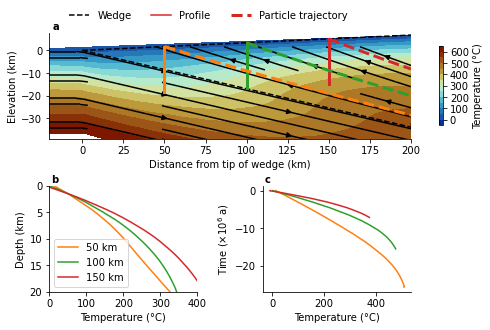

In [20]:
from matplotlib.gridspec import GridSpec

add_arrows = True
target_dist = np.array([50e3, 100e3, 150e3])
max_depth_gt = 20.0
    
if thermal_history_model == 'numerical':

    #fig, ax = pl.subplots(1, 1, figsize=(fig_width, fig_width / 1.5))
    fig = pl.figure(figsize=(fig_width, fig_width / 1.5), constrained_layout=True)
    
    gs = GridSpec(2, 2, figure=fig)
    ax = fig.add_subplot(gs[0, :])
    
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])
    
    
    # wedge only
    xlim = [-L/10/1e3, L / 1e3]
    ylim = [beta*L * 1.15 / 1000.0, alpha*L*1.15 / 1000.0]

    # full model domain
    #xlim = [-Lxmin / 1e3, L / 1e3]
    #ylim = [(beta*L * 1.1 - Ly) / 1000.0, (alpha*L * 1.1)/ 1000.0]

    ind = (Tx/1e3 >= xlim[0]) & (Tx/1e3 <= xlim[1]) & (Ty/1e3 >= ylim[0]) & (Ty/1e3 <= ylim[1])

    #ax.tricontour(Tx.value[ind] / 1e3, Ty.value[ind] / 1e3, T.value[ind], levels=10, linewidths=0.5, colors='k')#, vmin=vlims[1][0], vmax=vlims[1][1])
    #sci = ax.tricontourf(Tx.value[ind] / 1e3, Ty.value[ind] / 1e3, T.value[ind], levels=10, cmap=cmap_heat)#, vmin=vlims[1][0], vmax=vlims[1][1])
    #sci = ax.scatter(Tx.value[ind] / 1e3, Ty.value[ind] / 1e3, c=T.value[ind], s=1, cmap=cmap_heat)#, vmin=vlims[1][0], vmax=vlims[1][1])

    #ind = (xTm/1e3 >= xlim[0].value) & (xTm/1e3 <= xlim[1].value) & (yTm/1e3 >= ylim[0].value) & (yTm/1e3 <= ylim[1].value)

    sci = ax.contourf(xTm / 1e3, yTm / 1e3, Tm, cmap=cmap_heat, vmin=-25, vmax=600, levels=np.arange(-50, 700, 50))
    #sci = ax.pcolormesh(xTm / 1e3, yTm / 1e3, Tm, cmap=cmap_heat)
    
    #cb = fig.colorbar(sci, ax=ax, shrink=0.45, location='top', anchor=[0.0, 1.0])
    cb = fig.colorbar(sci, ax=ax, shrink=0.75, location='right')#, anchor=(0.0, 1.0))
    cb.set_label(f'Temperature ({degree_symbol}C)')

    #for i, xsi, ysi in zip(itertools.count(), x_samples, y_samples):
    #    ll, = ax.plot(xsi / 1000.0, ysi / 1000.0, color='black', lw=0.25, alpha=1.0)
        #scs.append(sci)

    #axs[1].set_xlim(-L/5/1e3, L / 1e3)
    #axs[1].set_ylim(beta*L * 1.1 / 1000.0, alpha*L*1.1 / 1000.0)
    #ax.set_xlim(0, 200000)
    #ax.set_ylim(-30000, 7000)
    
    if add_arrows is True:
        qint = 50
        qscale = 5e-9
        qheadlength = 4
        qheadwidth = 5
        
        indq = (qx/1e3 >= xlim[0].value) & (qx/1e3 <= xlim[1].value) & (qy/1e3 >= ylim[0].value) & (qy/1e3 <= ylim[1].value)
        #ax.quiver(qx[indq][::qint] / 1e3, qy[indq][::qint] / 1e3, qxa[indq][::qint], qya[indq][::qint], 
        #          angles='xy', scale=qscale, headwidth=qheadwidth, headlength=qheadlength)
    
    ax.streamplot(xgm / 1e3, ygm / 1e3, qxm, qym, color='black', density=1.0, integration_direction='backward')

    lw, = ax.plot([0, L_ / 1e3], [0, alpha * L_ / 1e3], color='black', ls='--')
    ax.plot([0, L_ / 1e3], [0, beta * L_ / 1e3], color='black', ls='--')
    
    
    #################################
    # panel with geothermal gradients
    #################################
    
    #xTm, yTm, Tm
    dTm =  xTm * alpha - yTm
    
    xTmu = np.unique(xTm)
    inds = [np.argmin(np.abs(xTmu - tdi)) for tdi in target_dist]
    target_dist2 = np.array([xTmu[i] for i in inds])
    
    cmap_lines = pl.get_cmap("tab10")
    
    for i, t1, t2 in zip(itertools.count(), target_dist, target_dist2):
        
        color = cmap_lines(i+1)
        
        ind = xTm == t2
        xgt =  xTm[ind]
        ygt = yTm[ind] / 1e3
        dgt = dTm[ind] / 1e3
        zgt = Tm[ind]
        ind2 = dgt < max_depth_gt
        ax2.plot(zgt, dgt, label=f"{t1 / 1e3 :0.0f} km", color=color)
        ax.plot([t1 / 1e3, t1 / 1e3], [t1 / 1e3 * alpha, ygt[ind2].min()], lw=3.0, color=color)
        
        ind10 = (dgt < 10) & (np.isnan(zgt)==False)
        gt10 = (zgt[ind10].max() -zgt[ind10].min() ) / (dgt[ind10].max() - dgt[ind10].min())
        print(f"gradient in upper 10 km = {gt10}")
    ax2.legend()
    
    #####################
    # panel with temperature history
    ####################
    xp0 = xp[:, 0]
    xp0[-1] = L
    
    indp = np.zeros_like(xp0.value, dtype=bool)
    
    for td in target_dist:
        a = np.argmin(np.abs(xp0.value - td))
        indp[a] = True
    xp_plot = xp[indp]
    yp_plot = yp[indp]
    
    for i, xp_plot_i, yp_plot_i in zip(itertools.count(), xp_plot, yp_plot):
        leg_th, = ax.plot(xp_plot_i / 1e3, yp_plot_i / 1e3, color=cmap_lines(i+1), ls='--', lw=3.0)
    
    T_history_plot = wedgex_model_functions.interpolate_thermal_history(xp_plot, yp_plot, Tx, Ty, T)
    
    for i, Thi in enumerate(T_history_plot):
        ind = np.isnan(Thi) == False
        tplot = t[ind].to(u.year).value / 1e6
        temp_plot = Thi[ind]
        #ax3.plot(tplot, temp_plot, color=cmap_lines(i+1))
        leg_gt, = ax3.plot(temp_plot, tplot, color=cmap_lines(i+1))
        
    # add closure temp
    cas = np.zeros((len(target_dist), len(thermochron_systems))) * u.s
    cts = np.zeros((len(target_dist), len(thermochron_systems))) * u.K
    for i, Thi in enumerate(T_history_plot):
        Tpi = Thi.to(u.K, equivalencies=u.temperature()) 
        ind = np.isnan(Tpi) == False
        for j, tcs in enumerate(thermochron_systems):
            cas[i, j], cts[i, j] = wedgex_model_functions.calculate_closure_age(-t[ind], Tpi[ind], tcs)
            
    
    ###########
    # layout
    ###########
    for i, axi in enumerate([ax, ax2, ax3]):
        axi.spines['top'].set_visible(False)
        axi.spines['right'].set_visible(False)
        axi.text(0.01, 1.01, string.ascii_lowercase[i], 
            weight='bold', transform=axi.transAxes, 
               ha='left', va='bottom', fontsize='medium')

    ax.set_xlabel('Distance from tip of wedge (km)')
    ax.set_ylabel('Elevation (km)')

    ax2.set_xlabel(f'Temperature ({degree_symbol}C)')
    ax2.set_ylabel("Depth (km)")

    ax3.set_ylabel(r'Time ($\times 10^{6} \; a$)')
    ax3.set_xlabel(f'Temperature ({degree_symbol}C)')

    ax.legend([lw, leg_gt, leg_th], ['Wedge', "Profile", "Particle trajectory", 'Particle trajectories'], 
              bbox_to_anchor=(0.03, 1.03), loc='lower left', frameon=False, ncol=3)

    #ax.set_aspect('equal')
    
    ax.set_xlim(xlim[0].value, xlim[1].value)
    ax.set_ylim(ylim[0].value, ylim[1].value)

    ax2.set_ylim(20, 0)
    ax2.set_xlim(0, 400)

    #fig.tight_layout()

    fig.savefig('fig/modelled_temperature_field.pdf')


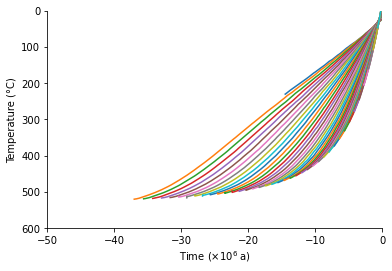

In [21]:
fig, ax = pl.subplots(1, 1)

for i, Thi in enumerate(T_history_points[:-1]):
    ind = np.isnan(Thi) == False
    ax.plot(t[ind].to(u.year).value / 1e6, Thi[ind])
    #print(Thi[ind].min())
ax.set_xlim(-50, 0)
ax.set_ylim(600, 0)

ax.set_xlabel(r'Time ($\times 10^{6} \; a$)')
ax.set_ylabel(f'Temperature ({degree_symbol}C)')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


## Interpolate temperature history for samples

In [22]:
from importlib import reload

wedgex_model_functions = reload(wedgex_model_functions)


if thermal_history_model is 'numerical':
    # merge xy grid points of numerical model into one array
    T_history_samples = wedgex_model_functions.interpolate_thermal_history(x_samples, y_samples, Tx, Ty, T) 
        
else:
    
    print('using a steady geothermal gradient to calculate temperature history')
    # calculate surface temperature
    #surface_temp_samples = surface_temperature_sea_lvl - lapse_rate * xp
    #resetting_depths = (resetting_temperatures - surface_temp_samples) / geothermal_gradient

    #target_depths_samples = resetting_depths

    n_samples = len(x_samples)

    #modelled_age_samples = np.zeros((n_samples))
    T_history_samples = np.zeros(x_samples.shape) * u.deg_C
    
    y0_samples = x_samples * alpha
    
    for j, y0s, xs, ds in zip(list(range(n_samples)), y0_samples, x_samples, d_samples):

        surface_Ts = surface_temperature_sea_lvl + y0s * lapse_rate
        
        ind = np.isnan(ds) == False
        
        if np.any(ind):
        
            T_history_samples[j] = surface_Ts + ds * geothermal_gradient

<>:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-22-77c29d33218f>:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if thermal_history_model is 'numerical':


# Calculate thermochron ages for all seed points

In [23]:
from importlib import reload

wedgex_model_functions = reload(wedgex_model_functions)


# model ages for entire model domain
n_seed_pts = len(xp)
n_thermochron = len(thermochron_systems)
modelled_ages_all = np.zeros((n_seed_pts, n_thermochron)) * u.year


# calculate surface temperature
#df['surface_T'] = surface_temperature_sea_lvl - lapse_rate * df['elevation']
#df['resetting_depth'] = (df['resetting_temp'] - df['surface_T']) / geothermal_gradient


closure_temps_seed_pts = np.zeros((n_seed_pts, n_thermochron)) * u.K

for i, tcs in enumerate(thermochron_systems):

    for j in range(n_seed_pts):

        Tpi = T_history_points[j].to(u.K, equivalencies=u.temperature()) 
        ind = np.isnan(Tpi) == False

        ti = -t[ind]

        if len(-t[ind]) > 1:

            if thermochron_model == 'simple':
                modelled_ages_all[j, i] = wedgex_model_functions.calculate_closure_age_simple(-t[ind], Tpi[ind], resetting_temperatures[i])
            else:
                modelled_ages_all[j, i], ct = wedgex_model_functions.calculate_closure_age(-t[ind], Tpi[ind], tcs)

                closure_temps_seed_pts[j, i] = ct
        #          res_temp_pts = np.ones(len(x0s)) * resetting_temperatures[i]
        #modelled_ages_all[:, i] = wedgex_model_functions.calculate_cooling_ages_simple(
        #    t, xp, dp, res_temp_pts, T_history_points,
        #    surface_temperature_sea_lvl, lapse_rate, geothermal_gradient, default_exhumation_rate, L)

 
            #t, x_samples, d_samples, resetting_temperatures_samples, T_history_samples,
            #                       surface_temperature_sea_lvl, lapse_rate, geothermal_gradient,
            #                       default_exhumation_rate, L,

## Calculate thermochron ages for samples

In [24]:
import imp
imp.reload(wedgex_model_functions)

#n_seed_pts = len(xp)
#n_thermochron = len(thermochron_systems)

n_samples = len(x_samples)
modelled_ages_samples = np.zeros((n_samples)) * u.year

for i, tcs in enumerate(thermochron_systems):

    inds = thermochron_system_samples == tcs

    for j in range(n_samples):
        if inds[j] == True:
            Tpi = T_history_samples[j].to(u.K, equivalencies=u.temperature()) 
            ind_ok = np.isnan(Tpi) == False

            ti = -t[ind_ok]

            if len(-t[ind_ok]) > 1:
                
                if thermochron_model == 'simple':
                    modelled_ages_samples[j] = wedgex_model_functions.calculate_closure_age_simple(-t[ind_ok], Tpi[ind_ok], resetting_temperatures[i])
                else:
                    modelled_ages_samples[j], ct = wedgex_model_functions.calculate_closure_age(-t[ind_ok], Tpi[ind_ok], tcs)

IndexError: index 0 is out of bounds for axis 0 with size 0

## Calculate model fit

In [ ]:
ct

In [ ]:
data = measured_ages
prediction = modelled_ages_samples

ind_nok = (np.isnan(data)) | (np.isnan(prediction))

data = data[ind_nok==False]
prediction = prediction[ind_nok==False]
unc_adj = measured_ages_sigma[ind_nok==False]
x0_samples_adj = x0_samples[ind_nok==False]

ME = np.mean(data - prediction)
MAE = sklearn.metrics.mean_absolute_error(data.to(u.yr).value, prediction.to(u.year).value) * u.year
R2 = sklearn.metrics.r2_score(data, prediction)
RMSE = sklearn.metrics.mean_squared_error(data, prediction, squared=False)

misfit_ind = (data - prediction)**2 / (unc_adj**2)

misfit = wedgex_model_functions.misfit_function(data, unc_adj, prediction)

print(f'mean error of this model run = {ME:0.2e}\n'
      f'mean absolute error {MAE:0.2e}\n'
      f'coefficient of determination = {R2}\n'
      f'RMSE = {RMSE} \n'
      f'misfit = {misfit}')

## Calculate exhumation rate

In [ ]:
dd = np.diff(dp, axis=1)
exhumation_rate = dd[:, 0] / (t[0] - t[1])

## Make a figure with the model results

In [ ]:
xcoords = np.linspace(0, L, 101)
y_top = xcoords * alpha
y_bottom = xcoords * beta

xpi, ypi = xp, yp
dpi = dp

legs = []
labels = []

fig, axs = pl.subplots(2, 1, figsize=(fig_width, fig_width * fig_height), sharex=True)

#############################
# panel with thermochron ages
#############################
for i, thc, color in zip(itertools.count(), thermochron_systems,  thermochron_colors):
    if thc in df[thermochronometer_col].values:
        lt, = axs[0].plot(x0s / 1e3, modelled_ages_all[:, i].to(u.yr) / 1e6, color=color)
        legs.append(lt)
        labels.append('%s model' % thc)
        
for thc, m, color in zip(thermochron_systems_plot, thermochron_markers, thermochron_colors):
    
    ix = df[thermochronometer_col] == thc
    
    if np.any(ix) == True:
        #axs[0].scatter(df.loc[ix, distance_column] / 1e3, df.loc[ix, 'age'], 
        # label='%s data' % thc, color=c, marker=m)
        
        x = df.loc[ix, distance_column] / 1e3
        z = df.loc[ix, 'age']
        ze = df.loc[ix, 'age_error_1s'] * 2
        sc = axs[0].errorbar(x, z, yerr=ze, ls='None', color=color, marker=m)
        legs.append(sc)
        labels.append('%s data' % thc)

#
if log_scale_ages is True:
    axs[0].set_yscale('log')    
else:
    axs[0].set_ylim(0, max_age_fig.value / 1e6)
axs[0].set_ylabel('Age (Ma)')

tekst = rf'$R^2$ = {R2:0.2f}, MAE={MAE.to(u.year).value / 1e6:0.2f} $\times 10^6$ a'# % (R2, MAE)
if add_equation is True:
    tekst += '\n'
    tekst += '$v_c$=%0.1e, $v_d$=%0.1e, $v_{xa}$=%0.1e ,$v_{ya}$=%0.1e ' \
                % (vc, vd, vxa, vya)
txt = axs[0].text(0.03, 0.97, tekst, transform=axs[0].transAxes, 
                  ha='left', va='top', fontsize='small')
txt.set_bbox(dict(facecolor='white', alpha=0.5, color='white'))

################################
# 2nd axis with exhumation rate
################################
axr = axs[0].twinx()

le, = axr.plot(xp[:, 0] / 1e3, exhumation_rate, color='gray', ls='--')
legs.append(le)
labels.append('exhumation')
axr.set_ylabel(r'Exhumation rate ($m a^{-1}$)')
axr.set_ylim(0, axr.get_ylim()[-1] * 1.25)

if add_legend is True:
    axs[0].legend(legs, labels, fontsize=fs, loc='lower right', facecolor='white', framealpha=1)

#######################
# particle trajectories
#######################

ax = axs[-1]

ind = xpi > L
xpi[ind] = np.nan
ypi[ind] = np.nan

for xl, yl in zip(xpi[::starting_pt_int], ypi[::starting_pt_int]):
    leg_traj, = ax.plot(xl / 1e3, yl / 1e3, ls='--', color='black')
    
    x, y = xl[::-arrow_int] / 1e3, yl[::-arrow_int] / 1e3
    U, V = x[1:]-x[:-1], y[1:]-y[:-1]
    #U = U / np.sqrt(U**2 + V**2)
    #V = V / np.sqrt(U**2 + V**2)
    leg_qv = ax.quiver(x[:-1].value, y[:-1].value, U.value, V.value, 
                        scale_units='xy', angles='xy', scale=scale)

nt = xpi.shape[1]

if isochrons is None:
    isochron_ts = np.linspace(0, nt - 1, 5).astype(int)
else:
    isochron_ts = [np.argmin(np.abs(-t - chron)) for chron in isochrons]

for i, nti in enumerate(isochron_ts):
    #leg_ts =  ax.scatter(xpi[:, nti] / 1e3, ypi[:, nti] / 1e3, s=20, color='black')
    leg_tsl, =  ax.plot(xpi[:, nti] / 1e3, ypi[:, nti] / 1e3, color='gray', ls='-', lw=1.5)
    
    tekst = f'{isochrons[i] / 1e6} Ma'
    text_buffer = 5
    xt, yt = xpi[:, nti].value / 1e3 + text_buffer, ypi[:, nti].value / 1e3
    ind = (np.isnan(xt) == False) & (np.isnan(yt) == False)
    
    if np.any(ind):
        txt = ax.text(L.value / 1e3 + text_buffer, yt[ind][-1], tekst, 
                      ha='left', va='center', weight='bold', color='gray')
        #txt.set_bbox(dict(facecolor='white', alpha=0.5, color='white'))
    pass

legs_tc = []
labels_tc = []

#for thc, m, c in zip(thermochron_systems[::-1], thermochron_markers[::-1], thermochron_colors[::-1]):
for i, thc, m, color in zip(itertools.count(), thermochron_systems_plot, thermochron_markers, thermochron_colors):
     
    ix = df[thermochronometer_col] == thc
        
    if np.any(ix) == True:
        labels_tc.append('%s data location' % thc)
        li = ax.scatter(df.loc[ix, distance_column] / 1e3, df.loc[ix, 'elevation'] / 1e3, 
                        edgecolor=color, facecolor='None', marker=m, zorder=10-i, lw=1.5, s=75)
        legs_tc.append(li)
        
#leg_s = ax.scatter(df['distance'], df['elevation'] / 1e3, label='thermochron samples')

leg_bnd, = ax.plot(xcoords / 1e3, y_top / 1e3, color='black', ls='--', lw=1.5)
ax.plot(xcoords / 1e3, y_bottom / 1e3, color='black', ls='--', lw=1.5)

ax.set_xlabel('Distance from tip of wedge (km)')
ax.set_ylabel('Elevation (km)')

for i, ax in enumerate(axs):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.text(0.01, 1.01, string.ascii_lowercase[i + first_subplot], 
            weight='bold', transform=ax.transAxes, 
               ha='left', va='bottom', fontsize='medium')

axr.spines['top'].set_visible(False)

if add_legend is True:
    legs = [leg_traj, leg_tsl, leg_bnd] + legs_tc
    labels = ['particle trajectories', 'isochron', 'wedge boundary'] + labels_tc
    axs[-1].legend(legs, labels, loc='lower left', ncol=2, fontsize=fs)

#fig.tight_layout()

for f in fig_formats:
    fn = fig_output_file + '.' + f
    print('saving figure as %s' % fn)
    fig.savefig(fn)

## Double check 

In [ ]:
import imp
imp.reload(wedgex_model_functions)

params_to_change = ['convergence', 'conv_part', 'deform_part', 'vxa', 'vya']
params = (1.76170905e-02 * u.m / u.year, 5.71132921e-01,  5.36513219e-01, 8.36008298e-06 * u.m / u.year, 0.0 * u.m / u.year)
#params = 
limit_params = True
calibration_metric = "RMSE"

# convert params to non-dimensional
# todo: double check why this is needed...
params_ = []

for p in params:
    if type(p) == u.quantity.Quantity:
        params_.append(p.value)
    else:
        params_.append(p)
        
params_ = 1.62740946e-02, 5.39300352e-01, 5.42245071e-01, 1.04312158e-05, 1.00363850e-05

args = (params_to_change, limit_params, t, x0_samples, alpha, beta, L, vc, vd, vxa, vya, 
        surface_temperature_sea_lvl, lapse_rate, geothermal_gradient,
        measured_ages, measured_ages_sigma, default_exhumation_rate,
        calibration_metric, 
        thermal_history_model, Ly, Lxmin, cellsize_wedge_top, cellsize_wedge_bottom, cellsize_footwall, 
        lab_temp, K, rho, c, H0, e_folding_depth, v_downgoing, 
        thermochron_model, thermochron_systems, thermochron_system_samples,
        resetting_temperatures)

a = wedgex_model_functions.compare_modelled_and_measured_ages(params_, *args)

#params, params_to_change, limit_params, t, x0_samples, 
#                                       alpha, beta, L, vc, vd, vxa, vya, 
#                                       surface_temperature_sea_lvl, lapse_rate, geothermal_gradient,
#                                       measured_ages, age_uncertainty,
#                                       default_exhumation_rate,
#                                       metric_to_return,
#                                       thermal_history_model,
#                                       Ly, Lxmin, cellsize_wedge_top, cellsize_wedge_bottom, cellsize_footwall, 
#                                       lab_temp, K, rho, c, H0, e_folding_depth, v_downgoing,
#                                       thermochron_model, thermochron_systems,


#        a = (L_, Ly_, alpha, beta, Lxmin_, cellsize_wedge_top_, cellsize_wedge_bottom_, cellsize_footwall_, 
#             vd_, vc_, vxa_, vya_, v_downgoing_, surface_temperature_sea_lvl, 
#             lapse_rate, lab_temp, 
#             K, rho, c, H0, e_folding_depth)

In [ ]:
ma = modelled_ages_samples[np.isnan(modelled_ages_samples)==False]
print("modelled ages, min., mean, max.: ", 
      ma.min(), 
      ma.mean(), 
      ma.max())

In [ ]:
T_.max()

## Read published results

In [ ]:
# published results
fnp = "data/thermochron_data_mcquarrie2015.csv"

dfp = pd.read_csv(fnp)

In [ ]:
dfp

In [ ]:
c

In [ ]:
meas_age_cols = ["data_AFT", "data_Zhe", "data_ArAr"]
model_age_cols = ["AFT_model", "Zhe_model", "Ar_Ar_model"]

published_distances = []
published_ages = []
published_model_ages = []
thermochron_system = []
for cd, cm in zip(meas_age_cols, model_age_cols):
    ind = dfp[cd].notnull()
    
    published_ages += dfp.loc[ind, cd].tolist()
    published_distances += dfp.loc[ind, "X"].tolist()
    published_model_ages += dfp.loc[ind, cm].tolist()
    
    thermochron_system += [cd] * np.sum(ind)

cp = ["distance", "measured_age", "modelled_age"]
dfps = pd.DataFrame(columns=cp, index=np.arange(len(published_ages)))

dfps["distance"] = published_distances
dfps["measured_age"] = published_ages
dfps["modelled_age"] = published_model_ages

dfps["thermochron_system"] = thermochron_system

dfps

In [ ]:
dfp

## Calculate model statistics for published results

In [ ]:
data_pub, pred_pub = dfps['measured_age'].values * 1e6 * u.year, dfps['modelled_age'].values * 1e6 * u.year
d_pub = dfps['distance'].values

R2_pub = sklearn.metrics.r2_score(data_pub, pred_pub)
MAE_pub = sklearn.metrics.mean_absolute_error(data_pub, pred_pub)

# only first 80 km
dfpsi = dfps[dfps["distance"] < 75.0]
data_pub_80km, pred_pub_80km = dfpsi['measured_age'].values * 1e6 * u.year, dfpsi['modelled_age'].values * 1e6 * u.year
d_pub_80km = dfpsi['distance'].values


R2_pub_80km = sklearn.metrics.r2_score(data_pub_80km, pred_pub_80km)
MAE_pub_80km = sklearn.metrics.mean_absolute_error(data_pub_80km, pred_pub_80km)

fig, ax = pl.subplots(1, 1)

ax.scatter(data_pub, pred_pub, c=d_pub)
ax.plot([1e6, 5e7], [1e6, 5e7])

ax.set_xlabel("measured age")
ax.set_ylabel("modelled age")

ax.set_xscale("log")
ax.set_yscale("log")


print(f'model fit published models: R2 = {R2_pub:.2f}, MAE = {MAE_pub:.1e} a')
print(f'model fit published models first 80 km: R2 = {R2_pub_80km:.2f}, MAE = {MAE_pub_80km:.1e} a')

In [ ]:
d_pub

In [ ]:
#meas_age_cols = ["data_AFT", "data_Zhe", "data_ArAr"]
#model_age_cols = ["AFT_model", "Zhe_model", "Ar_Ar_model"]

# dict to find corresponding data/models for published data
thc_dict = {"AFT": {"data_col": "data_AFT", "model_col": "AFT_model"}, 
            "ZHe": {"data_col": "data_Zhe", "model_col": "Zhe_model"}, 
            "MAr": {"data_col": "data_ArAr", "model_col": "Ar_Ar_model"}}


legs = []
labels = []

fig, ax = pl.subplots(1, 1, figsize=(fig_width, fig_width /1.5))

#############################
# panel with thermochron ages
#############################
lp = None
for i, thc, color in zip(itertools.count(), thermochron_systems,  thermochron_colors):
    if thc in df[thermochronometer_col].values:
        lt, = ax.plot(x0s / 1e3, modelled_ages_all[:, i] / 1e6, color=color)
        legs.append(lt)
        labels.append('%s model' % thc)
        
        if thc in thc_dict.keys():
            
            x = dfp["X"]
            age = dfp[thc_dict[thc]["model_col"]]
                    
            #j = thermochron_syst_published.index(thc)
            
            #dft = dfts[j]
            #x = (dft['x'] - distance_correction) * dist_corr_factor
            #age = dft['y']
            
            lp, = ax.plot(x, age, color=color, ls=':')
            
for thc, m, color in zip(thermochron_systems_plot, thermochron_markers, thermochron_colors):
    
    ix = df[thermochronometer_col] == thc
    
    if np.any(ix) == True:
        #axs[0].scatter(df.loc[ix, distance_column] / 1e3, df.loc[ix, 'age'], 
        # label='%s data' % thc, color=c, marker=m)
        
        c2 = thc_dict[thc]["data_col"]
        ind2 = dfps["thermochron_system"] == c2
        x2 = dfps.loc[ind2, "distance"].values
        z2 = dfps.loc[ind2, "measured_age"].values
        sc2 = ax.scatter(x2, z2, color="gray", marker=m, edgecolor='black', lw=0.5)
        
        x = df.loc[ix, distance_column] / 1e3
        z = df.loc[ix, 'age']
        ze = df.loc[ix, 'age_error_1s'] * 2
        sc = ax.errorbar(x, z, yerr=ze, ls='None', color=color, marker=m)
        legs.append(sc)
        labels.append('%s data' % thc)

if lp is not None:           
    legs.append(lp)
    labels.append('Models, McQuarrie & Ehlers (2015)')
 

legs.append(sc2)
labels.append("Data locations McQuarrie & Ehlers (2015)")
#
if log_scale_ages is True:
    ax.set_yscale('log')    
else:
    ax.set_ylim(0, max_age_fig.value / 1e6)
    
ax.set_xlim(0, 200)
ax.set_ylabel('Age (Ma)')
ax.set_xlabel('Distance from tip of wedge (km)')

tekst = rf'analytical solution: $R^2$={R2:0.2f}, MAE={MAE.value:0.2e} a'
tekst += '\n'
tekst += rf'McQuarrie & Ehlers (2015): $R^2$={R2_pub:0.2f}, MAE={MAE_pub:0.2e} a'
txt = ax.text(0.03, 0.97, tekst, transform=ax.transAxes, 
                  ha='left', va='top', fontsize='medium')
txt.set_bbox(dict(facecolor='white', alpha=0.5, color='white'))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(legs, labels, fontsize=fs, facecolor='white', framealpha=1, bbox_to_anchor=(0.05, 1), loc='lower left', ncol=2)

fig.tight_layout()

fig.savefig('fig/comparison_mcquarrie2015.pdf')
fig.savefig('fig/comparison_mcquarrie2015.png')



## Parameter space search

Use the box below to switch parameter space search on or off. Note that this can be quite time consuming

## Define parameter ranges for the parameter search

In [ ]:
#vc_range = np.linspace(-1e-3, -20e-3, n_ints)
#vd_range = np.linspace(-1e-3, -10e-3, n_ints)
multipliers = np.array([1/2, 2/3., 1.0, 3/2, 2.])
additions = np.arange(-4e-3, 5e-3, 1e-3)

additions2 = np.arange(-2e-3, 3e-3, 1e-3)
additions3 = np.arange(-2e-4, 3e-4, 1e-4)

vc_range =  vc + additions
vd_range =  vd + additions

#vxa_range = np.linspace(0, 1e-3, n_ints)
#vya_range = np.linspace(0.0, 1e-3, n_ints)
vxa_range = vxa + additions2
vya_range = vya + additions3

vc_range = vc_range[vc_range < 0] 
vd_range = vd_range[vd_range < 0]

vxa_range = vxa_range[vxa_range >= 0]
vya_range = vya_range[vya_range >= 0]

## The actual parameter space search

In [ ]:
#%%timeit

if parameter_space_search is True:
    
    metric_to_return = 'R2'
    
    n_ints = 5

    scenario_parameter_list = [vc_range, vd_range, vxa_range, vya_range]

    param_combs = list(itertools.product(*scenario_parameter_list))

    print('testing %i parameter combinations' % len(param_combs))
    print('this may take some time')

    error_stats_all = []

    nc = len(param_combs)

    for i, p in enumerate(param_combs):

        if nc > 100 and float(i / 100) == int(i / 100):
            print('parameter combination %i of %i' % (i+1, nc))

        error_stats = wedgex_model_functions.compare_modelled_and_measured_ages(
            p, params_to_change, limit_params, t, x0_samples, 
             alpha, beta, L, vc, vd, vxa, vya, 
             surface_temperature_sea_lvl, 
             lapse_rate, geothermal_gradient,
             measured_ages, measured_ages_sigma, resetting_temperatures_samples,
             default_exhumation_rate,
             metric_to_return)
                
        error_stats_all.append(error_stats)

    print('done testing parameter combinations')

In [ ]:
if parameter_space_search is True:
    param_combs_array = np.array(param_combs)
    model_errors = np.array(error_stats_all)

## Make a figure of parameter space search 

In [ ]:
def unique_rows(a):
    """
    remove duplicate rows from an array

    found on stackoverflow:
    http://stackoverflow.com/questions/8560440/
    removing-duplicate-columns-and-rows-from-a-numpy-2d-array

    :param a:
    :return:
    """
    a = np.ascontiguousarray(a)
    unique_a = np.unique(a.view([('', a.dtype)]*a.shape[1]))

    return unique_a.view(a.dtype).reshape((unique_a.shape[0], a.shape[1]))

if parameter_space_search is True:
    z = model_errors[:]

    vmin = 0.0
    vmax = 1.0

    param_combs_plots = [[0, 1], [2, 3]]

    ax_labels = [[r'$v_c \; (m\;s^{-1})$', r'$v_d \; (m\;s^{-1})$'], 
                 [r'$v_{xa} \; (m\;s^{-1})$', r'$v_{ya} \; (m\;s^{-1})$']]

    fig, axs = pl.subplots(1, 2, figsize=(8, 4))

    for ax, pc, al in zip(axs, param_combs_plots, ax_labels):

        # get min error for each overlapping pt:
        v1 = param_combs_array[:, pc[0]]
        v2 = param_combs_array[:, pc[1]]
        a = np.vstack([v1, v2]).T
        ur = unique_rows(a)

        zs = np.zeros(len(ur))

        for i, ui in enumerate(ur):
            ind = (a[:, 0] == ui[0]) & (a[:, 1] == ui[1])
            zs[i] = np.max(z[ind])


        sc = ax.scatter(ur[:, 0], ur[:, 1], c=zs,
                   vmin=vmin, vmax=vmax, s=100, cmap=cmap)

        ax.set_xlabel(al[0])
        ax.set_ylabel(al[1])

    fig.subplots_adjust(bottom=0.32, wspace=0.5)

    cax = fig.add_axes([0.25, 0.12, 0.5, 0.02])

    cb = fig.colorbar(sc, cax=cax, orientation='horizontal')
    cb.set_label(r'$R^2$')

    for i, ax in enumerate(axs):
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.text(0.01, 1.01, string.ascii_lowercase[i], 
                weight='bold', transform=ax.transAxes, 
                   ha='left', va='bottom', fontsize='medium')

    #fig.tight_layout()

    fig.savefig('fig/parameter_space_exp.png')
    fig.savefig('fig/parameter_space_exp.pdf')
